In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import sys
sys.path.append('/Users/familyafanasyevy/Documents/Денис/Skillfactory/vulnerable_populations/additional_functions')
from model_functions import to_evaluate_optimal_metrics
from functions import outliers_z_score, stat_test

##### Прочитаем собранные данные.

In [2]:
merged_data = pd.read_csv('merged_data.csv', index_col=0)
merged_data.head()

,"Динамика населения на 2016 г., в %","Динамика населения на 2018 г., в %","Динамика населения на 2020 г., в %","Динамика населения на 2021 г., в %","Динамика населения на 2022 г., в %","Динамика среднедушевых денежных доходов на 2019 г., в %","Динамика среднедушевых денежных доходов на 2020 г., в %",Реальные денежные доходы в 2016 году в % к предыдущему году,Реальные денежные доходы в 2017 году в % к предыдущему году,Реальные денежные доходы в 2018 году в % к предыдущему году,...,Динамика новорождённых в 2020 году,Динамика новорождённых в 2021 году,"Отношение числа умерших за 2015 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2016 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2017 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2018 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2019 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2020 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2019 год детей в сельской местности к числу новорожденных, в %","Отношение числа умерших за 2020 год детей в сельской местности к числу новорожденных, в %"
Белгородская область,0.142189,-0.192483,0.111993,-0.509440,-0.606128,5.114042,1.511499,100.8,99.1,98.7,...,-6.410062,-1.044365,0.380654,0.417125,0.284523,0.279369,0.174269,0.202396,0.121230,0.178109
Брянская область,-0.583889,-0.782283,-0.641233,-0.822564,-1.176225,6.718074,0.793063,95.0,99.4,102.1,...,-5.464699,-4.567511,0.476292,0.500785,0.562624,0.296656,0.259274,0.305907,0.109693,0.126582
Владимирская область,-0.600805,-0.810450,-0.541000,-1.201178,-1.373967,7.727601,2.224150,92.2,100.9,96.4,...,-9.302742,-3.359684,0.466716,0.459711,0.440463,0.355506,0.385374,0.503953,0.134433,0.098814
Воронежская область,0.099951,-0.070223,-0.155338,-0.800145,-0.777669,5.721549,0.174880,93.6,97.4,100.0,...,-2.453800,-2.964355,0.389600,0.384955,0.401374,0.360116,0.376725,0.302698,0.035636,0.062627
Ивановская область,-0.681931,-0.833097,-0.701567,-1.013203,-1.024688,5.268743,1.872528,98.5,100.4,94.4,...,-4.879889,-3.120455,0.408129,0.456009,0.313860,0.306547,0.389888,0.330557,0.113193,0.039667


##### Здесь я предлагаю удалить те регионы, которые имеют выбросы. На самом деле, скорее всего, большинство, если не все, регионов будут иметь выбросы в каком-нибудь признаке. Но я предлагаю поступить следующим образом: будем проверять, имеет ли признак нормальное распределение, и если это так, то по этому признаку будем искать выбросы. Определять, нормальное ли распределение у признака, будем по тесту на нормальность Д'Агостино.

In [3]:
regions_for_drop = set()
for feature in merged_data.columns:
    outliers = []
    if stat_test(merged_data[feature]):
        outliers = outliers_z_score(merged_data, feature).index
    for region in outliers:
        regions_for_drop.add(region)
print(regions_for_drop)
print(f"Удалим {len(regions_for_drop)} регионов.")

{'Севастополь', 'Ленинградская область', 'Тюменская область', 'Республика Алтай', 'Ненецкий автономный округ', 'Сахалинская область', 'Калужская область', 'Республика Крым', 'Чукотский автономный округ'}
Удалим 9 регионов.


##### Стандартизируем признаки.

In [4]:
ss_scaler = StandardScaler()
ss_scaler.fit(merged_data)
merged_data_scaler = pd.DataFrame(data=ss_scaler.transform(merged_data), index=merged_data.index, columns=merged_data.columns)
merged_data_scaler.head()

,"Динамика населения на 2016 г., в %","Динамика населения на 2018 г., в %","Динамика населения на 2020 г., в %","Динамика населения на 2021 г., в %","Динамика населения на 2022 г., в %","Динамика среднедушевых денежных доходов на 2019 г., в %","Динамика среднедушевых денежных доходов на 2020 г., в %",Реальные денежные доходы в 2016 году в % к предыдущему году,Реальные денежные доходы в 2017 году в % к предыдущему году,Реальные денежные доходы в 2018 году в % к предыдущему году,...,Динамика новорождённых в 2020 году,Динамика новорождённых в 2021 году,"Отношение числа умерших за 2015 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2016 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2017 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2018 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2019 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2020 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2019 год детей в сельской местности к числу новорожденных, в %","Отношение числа умерших за 2020 год детей в сельской местности к числу новорожденных, в %"
Белгородская область,0.189711,-0.041365,0.352382,-0.100777,-0.153531,-0.427965,-0.443651,0.929241,-0.157998,-0.715378,...,-0.956669,0.839072,-0.455449,0.097705,-0.863242,-0.643916,-1.491943,-0.851970,-0.353876,0.241857
Брянская область,-0.715026,-0.899193,-0.707034,-0.290337,-0.819160,0.642649,-0.713723,-0.057015,-0.005386,0.588180,...,-0.700432,-0.485580,0.419817,0.829710,1.960627,-0.454877,-0.742039,-0.099647,-0.441434,-0.257843
Владимирская область,-0.736104,-0.940160,-0.566056,-0.519544,-1.050038,1.316460,-0.175755,-0.533138,0.757675,-1.597196,...,-1.740718,-0.031455,0.332176,0.470325,0.720185,0.188664,0.370395,1.339759,-0.253686,-0.527134
Воронежская область,0.137080,0.136455,-0.023620,-0.276765,-0.353817,-0.022483,-0.946107,-0.295076,-1.022801,-0.216959,...,0.115659,0.117183,-0.373572,-0.183782,0.323269,0.239070,0.294093,-0.122970,-1.003444,-0.878073
Ивановская область,-0.837192,-0.973099,-0.791894,-0.405747,-0.642230,-0.324709,-0.307935,0.538139,0.503321,-2.363995,...,-0.541922,0.058492,-0.204005,0.437926,-0.565349,-0.346716,0.410220,0.079507,-0.414870,-1.100741


##### И теперь оставляем только те регионы, которые не являются выбросами.

In [5]:
merged_data_cleaned = merged_data_scaler.drop(index=regions_for_drop)
merged_data_cleaned.head()

,"Динамика населения на 2016 г., в %","Динамика населения на 2018 г., в %","Динамика населения на 2020 г., в %","Динамика населения на 2021 г., в %","Динамика населения на 2022 г., в %","Динамика среднедушевых денежных доходов на 2019 г., в %","Динамика среднедушевых денежных доходов на 2020 г., в %",Реальные денежные доходы в 2016 году в % к предыдущему году,Реальные денежные доходы в 2017 году в % к предыдущему году,Реальные денежные доходы в 2018 году в % к предыдущему году,...,Динамика новорождённых в 2020 году,Динамика новорождённых в 2021 году,"Отношение числа умерших за 2015 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2016 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2017 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2018 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2019 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2020 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2019 год детей в сельской местности к числу новорожденных, в %","Отношение числа умерших за 2020 год детей в сельской местности к числу новорожденных, в %"
Белгородская область,0.189711,-0.041365,0.352382,-0.100777,-0.153531,-0.427965,-0.443651,0.929241,-0.157998,-0.715378,...,-0.956669,0.839072,-0.455449,0.097705,-0.863242,-0.643916,-1.491943,-0.851970,-0.353876,0.241857
Брянская область,-0.715026,-0.899193,-0.707034,-0.290337,-0.819160,0.642649,-0.713723,-0.057015,-0.005386,0.588180,...,-0.700432,-0.485580,0.419817,0.829710,1.960627,-0.454877,-0.742039,-0.099647,-0.441434,-0.257843
Владимирская область,-0.736104,-0.940160,-0.566056,-0.519544,-1.050038,1.316460,-0.175755,-0.533138,0.757675,-1.597196,...,-1.740718,-0.031455,0.332176,0.470325,0.720185,0.188664,0.370395,1.339759,-0.253686,-0.527134
Воронежская область,0.137080,0.136455,-0.023620,-0.276765,-0.353817,-0.022483,-0.946107,-0.295076,-1.022801,-0.216959,...,0.115659,0.117183,-0.373572,-0.183782,0.323269,0.239070,0.294093,-0.122970,-1.003444,-0.878073
Ивановская область,-0.837192,-0.973099,-0.791894,-0.405747,-0.642230,-0.324709,-0.307935,0.538139,0.503321,-2.363995,...,-0.541922,0.058492,-0.204005,0.437926,-0.565349,-0.346716,0.410220,0.079507,-0.414870,-1.100741


##### Поскольку проводить кластеризацию на всех 70 признаках, возможно, будет слишком долго, воспользуемся методом главных компонент - PCA - чтобы на основе имеющихся признаков отобрать наиболее важные линейные комбинации этих признаков.

## Кластеризация регионов на основе признаков, полученных алгоритмом PCA (метод главных компонент).

### Алгоритм KMeans.

##### Для алгоритма KMeans необходимо задавать число кластеров, на которые мы хотим разбить наши данные. В качестве метрик, по которым мы будем судить о том, какое число кластеров лучше всего взять, будем использовать коэффициент силуэта (в идеальном случае должен быть близок к 1) и индекс Дэвиса-Болдина (в идеальном случае должен быть близок к 0).

##### Для расчёта оптимального числа главных компонент алгоритма PCA и числа кластеров применим функцию из файла model_functions.py.

##### Сначала произведём расчёты для такого числа компонент, которые объясняли бы от 70 до 90% разброса в данных.

In [6]:
to_evaluate_optimal_metrics(merged_data_cleaned, np.arange(0.7, 0.9, 0.05), "KMeans", np.arange(2, 11))

Максимальный коэффициент силуэта, равный 0.306372, получается при 0.7 главных компонентах.
Число кластеров при максимальном коэффициенте силуэта - [3].
Минимальный индекс Дэвиса-Болдина, равный 1.282432, получается при 0.7 главных компонентах.
Число кластеров при минимальном индексе Дэвиса-Болдина - [10].


##### Теперь посчитаем для определённого числа компонент.

In [7]:
to_evaluate_optimal_metrics(merged_data_cleaned, np.arange(2, 10), "KMeans", np.arange(2, 11))

Максимальный коэффициент силуэта, равный 0.611472, получается при 2 главных компонентах.
Число кластеров при максимальном коэффициенте силуэта - [2].
Минимальный индекс Дэвиса-Болдина, равный 0.661369, получается при 2 главных компонентах.
Число кластеров при минимальном индексе Дэвиса-Болдина - [9].


##### Оптимальные метрики достигаются при 2 главных компонентах алгоритма PCA. Однако максимальный коэффициент силуэта получается при разбиении на 2 кластера, а минимальный индекс Дэвиса-Болдина - на 9 кластеров.
##### Более того можно заметить вот что: метрики, полученные при кластеризации алгоритмом KMeans на неочищенном наборе данных, были чуть хуже (0.59 для коэффициента силуэта и 0.6 - для индекса Дэвиса-Болдина).

##### Теперь на вычисленных наилучших гиперпараметрах разобьём регионы на кластеры.

Первая главная компонента объясняет 0.13 долю дисперсии.
Вторая главная компонента объясняет 0.13 долю дисперсии.


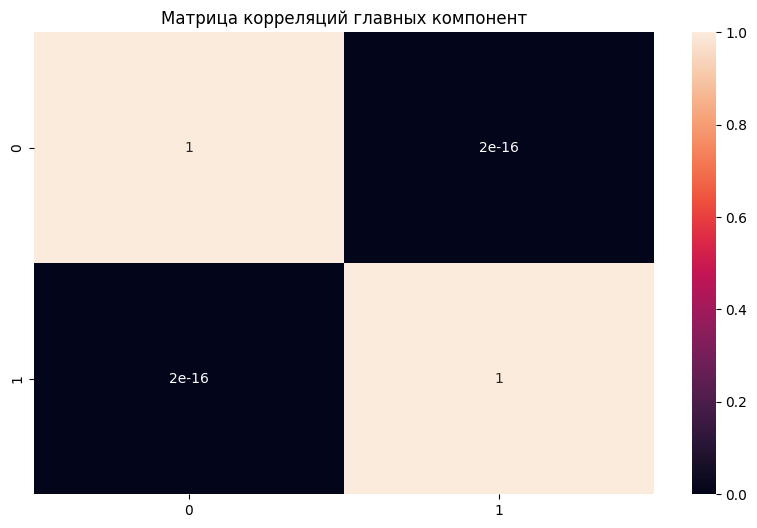

In [8]:
pca = PCA(n_components=2, random_state=42)
pca.fit(merged_data_cleaned)
data_pca = pca.transform(merged_data_cleaned)
print("Первая главная компонента объясняет {0} долю дисперсии.".format(np.round(pca.explained_variance_ratio_[0], 2)))
print("Вторая главная компонента объясняет {0} долю дисперсии.".format(np.round(pca.explained_variance_ratio_[1], 2)))

data_pca = pd.DataFrame(data=data_pca, index=merged_data_cleaned.index)
figure, axes = plt.subplots(figsize=(10, 6))
sns.heatmap(data=data_pca.corr(), ax=axes, annot=True)
axes.set_title("Матрица корреляций главных компонент");

##### К сожалению, 2 самых важных признака объясняют всего лишь 26% разброса данных. Однако это всё же чуть больше, чем было без удаления выбросов.

##### Построим визуализацию нашей плоскости признаков.

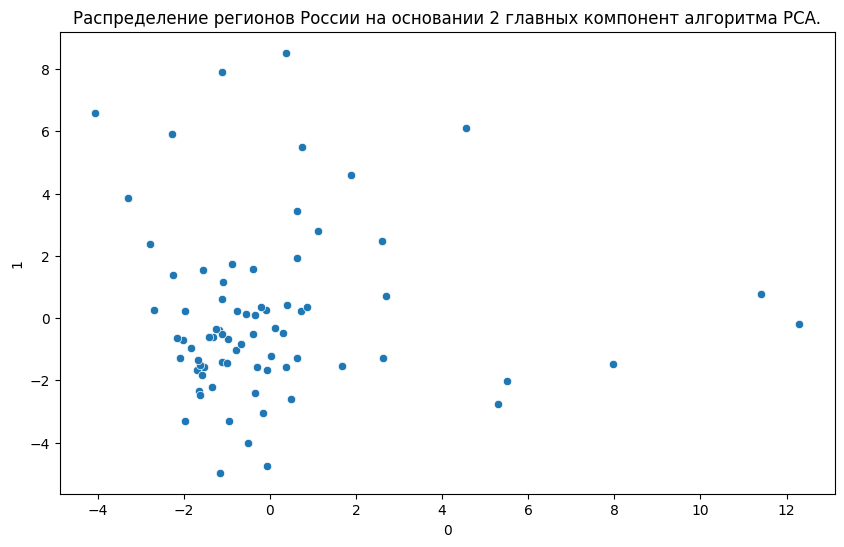

In [9]:
figure, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(data=data_pca, x=0, y=1, ax=axes)
axes.set_title('Распределение регионов России на основании 2 главных компонент алгоритма PCA.');

##### Проведём кластеризацию на 2 кластера.

In [10]:
k_means_opt = KMeans(n_clusters=2, random_state=42, n_init=10)
k_means_opt.fit(data_pca)
k_means_pca_2 = data_pca.copy()
k_means_pca_2['predict'] = k_means_opt.predict(k_means_pca_2)
k_means_pca_2.head()

,0,1,predict
Белгородская область,0.729875,0.220711,0
Брянская область,-1.527581,-1.563825,0
Владимирская область,-2.080174,-1.269753,0
Воронежская область,-0.392726,-0.499352,0
Ивановская область,-1.976528,-3.318093,0


##### Визуализируем получившиеся кластеры.

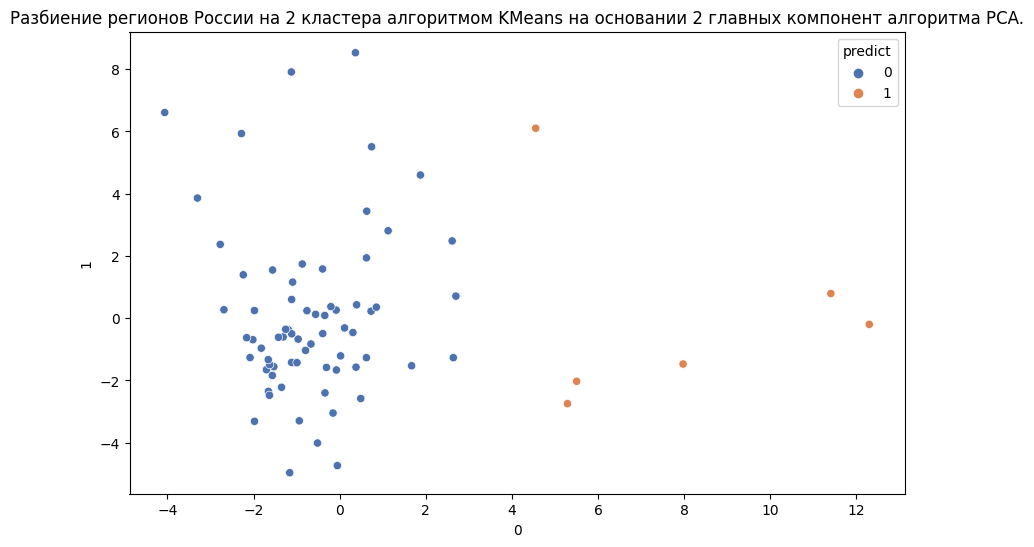

In [11]:
figure, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(data=k_means_pca_2, x=0, y=1, hue='predict', ax=axes, palette='deep')
axes.set_title('Разбиение регионов России на 2 кластера алгоритмом KMeans на основании 2 главных компонент алгоритма PCA.');

##### Проведём кластеризацию на 9 кластеров, руководствуясь полученным индексом Дэвиса-Болдина.

In [12]:
k_means_opt = KMeans(n_clusters=9, random_state=42, n_init=10)
k_means_opt.fit(data_pca)
k_means_pca_9 = data_pca.copy()
k_means_pca_9['predict'] = k_means_opt.predict(k_means_pca_9)
k_means_pca_9.head()

,0,1,predict
Белгородская область,0.729875,0.220711,0
Брянская область,-1.527581,-1.563825,3
Владимирская область,-2.080174,-1.269753,3
Воронежская область,-0.392726,-0.499352,3
Ивановская область,-1.976528,-3.318093,6


##### Визуализируем получившиеся кластеры.

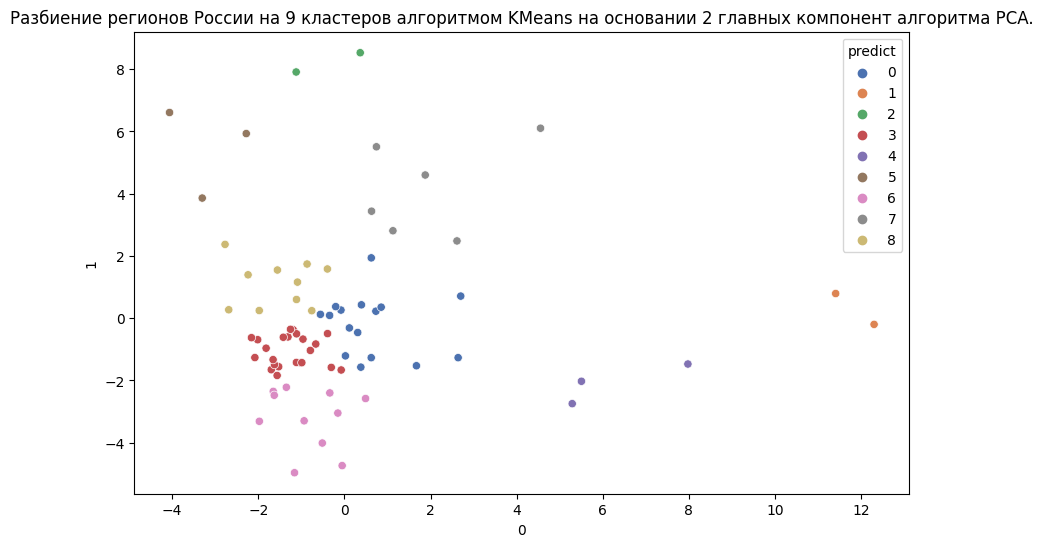

In [13]:
figure, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(data=k_means_pca_9, x=0, y=1, hue='predict', ax=axes, palette='deep')
axes.set_title('Разбиение регионов России на 9 кластеров алгоритмом KMeans на основании 2 главных компонент алгоритма PCA.');

##### Чтобы выбрать, какая всё-таки из 2 моделей - лучшая, воспользуемся индексом Калински-Харабаса.

In [14]:
print(f"Значение индекса Калински-Харабаса для алгоритма KMeans на 2 кластерах - {np.round(calinski_harabasz_score(data_pca, k_means_pca_2['predict']), 6)}.")
print(f"Значение индекса Калински-Харабаса для алгоритма KMeans на 9 кластерах - {np.round(calinski_harabasz_score(data_pca, k_means_pca_9['predict']), 6)}.")

Значение индекса Калински-Харабаса для алгоритма KMeans на 2 кластерах - 41.008435.
Значение индекса Калински-Харабаса для алгоритма KMeans на 9 кластерах - 83.793936.


##### Таким образом, поскольку значение индекса Калински-Харабаса больше при кластеризации на 9 кластеров, мы можем утверждать, что такое разбиение лучше, чем разбиение на 2 кластера.

### EM-алгоритм.

##### Настало время для мягкой кластеризации - EM-алгоритма.

In [15]:
to_evaluate_optimal_metrics(merged_data_cleaned, np.arange(2, 10), "GaussianMixture", np.arange(2, 11))

Максимальный коэффициент силуэта, равный 0.534292, получается при 2 главных компонентах.
Число кластеров при максимальном коэффициенте силуэта - [3].
Минимальный индекс Дэвиса-Болдина, равный 0.719805, получается при 3 главных компонентах.
Число кластеров при минимальном индексе Дэвиса-Болдина - [10].


##### Заметим, что EM-алгоритм отработал хуже, чем KMeans. Более того, эти значения хуже значений того же EM-алгоритма на неочищенных данных. В связи с этим дальнейшее разбиение на кластеры этим алгоритмом рассматривать не будем.

### Агломеративная кластеризация.

##### Пришло время для агломеративной кластеризации.

In [16]:
to_evaluate_optimal_metrics(merged_data_cleaned, np.arange(2, 10), "AgglomerativeClustering",  np.arange(2, 11))

Максимальный коэффициент силуэта, равный 0.621213, получается при 2 главных компонентах.
Число кластеров при максимальном коэффициенте силуэта - [2].
Минимальный индекс Дэвиса-Болдина, равный 0.588822, получается при 2 главных компонентах.
Число кластеров при минимальном индексе Дэвиса-Болдина - [2].


##### В случае агломеративной кластеризации у нас получился 1 набор оптимальных параметров. Заметим, что метрики получились лучше, чем при алгоритме KMeans (0.61 и 0.66 соответственно для коэффициента силуэта и индекса Дэвиса-Болдина). Более того это лучше, чем при алгоритме KMeans на неочищенном наборе данных.

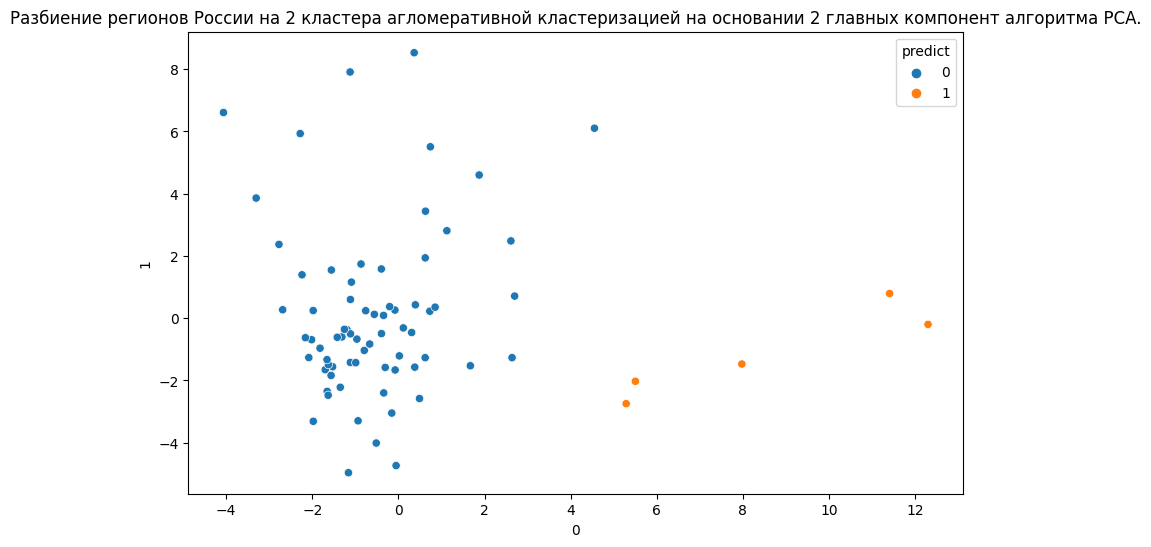

In [17]:
agglomerative_opt = AgglomerativeClustering(n_clusters=2)
agglomerative_opt.fit(data_pca)
agglomerative_pca = data_pca.copy()
agglomerative_pca['predict'] = agglomerative_opt.labels_

figure, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(data=agglomerative_pca, x=0, y=1, hue='predict', ax=axes)
axes.set_title('Разбиение регионов России на 2 кластера агломеративной кластеризацией на основании 2 главных компонент алгоритма PCA.');

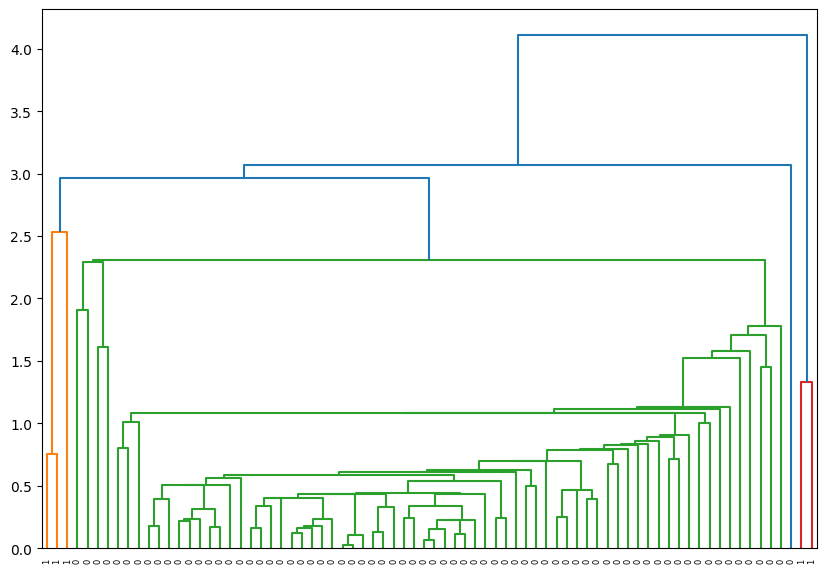

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(data_pca, 'single')


plt.figure(figsize=(10, 7))

dendrogram(linked,
            orientation='top',
            labels=agglomerative_opt.labels_,
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

##### Что ж: мы провели кластеризацию на очищенном наборе данных, и самым лучшим разбиением оказалось разбиение на 2 кластера с помощью алгоритма агломеративной кластеризации. Но как же быть в случае с регионами, которые у нас попали в выбросы.
##### Для них можно было бы так же понизить размерность с помощью алгоритма PCA. Но из-за особенностей агломеративной кластеризации у неё нет метода predict. То есть агломеративная кластеризация делает разбиение только для тех наблюдений (регионов), на которых она и обучается.
##### Таким образом, я предлагаю задачу кластеризации свести к задаче классификации.

## Класификация регионов-выбросов.

##### В отдельные переменные определим очищенный набор данных и метки кластеров.

In [19]:
X = agglomerative_pca.drop(columns='predict')
y = agglomerative_pca['predict']

##### Разделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
print("{0} регионов попали в тренировочную выборку.".format(X_train.shape[0]))
print("{0} регионов попали в тестовую выборку.".format(X_test.shape[0]))

60 регионов попали в тренировочную выборку.
16 регионов попали в тестовую выборку.


##### Нам осталось только построить модели классификации. И начнём с самой простейшей для этого логистической модели.

### Логистическая модель.

##### С помощью GridSearchCV организуем перебор гиперпараметров. В качестве метрики используем F1-score.

In [21]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.arange(0.1, 1.1, 0.1),
    'max_iter': np.arange(100, 1100, 100)
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'),
    param_grid=param_grid,
    scoring='precision',
    cv=4
)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
log_reg_opt = grid_search.best_estimator_

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.50      1.00      0.67         1

    accuracy                           0.94        16
   macro avg       0.75      0.97      0.82        16
weighted avg       0.97      0.94      0.95        16



##### Посмотрим, как меняются значения наших метрик в зависимости от вероятности принадлежности тому или иному классу.

/Users/familyafanasyevy/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/familyafanasyevy/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/familyafanasyevy/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/familyafanasyevy/Library/Python/3.9/

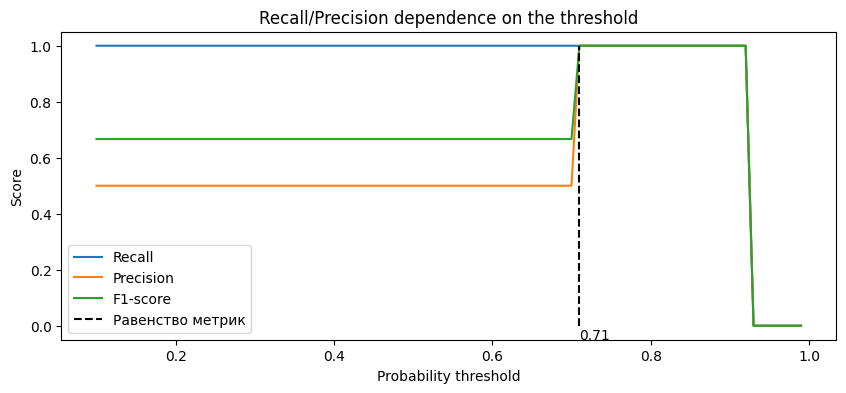

In [22]:
# считаем вероятности принадлежности к классам
y_test_proba_pred = grid_search.predict_proba(X_test)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)
# создадим списки, в которых будем хранить значения метрик
recall_scores = []
precision_scores = []
f1_scores = []
# сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.01)
for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    recall_scores.append(recall_score(y_test, y_test_pred))
    precision_scores.append(precision_score(y_test, y_test_pred))
    f1_scores.append(f1_score(y_test, y_test_pred))

# найдём порог, при котором метрики пересекаются
x = 0
for i, elem in enumerate(thresholds):
    if (recall_scores[i] == precision_scores[i]) and (recall_scores[i] == f1_scores[i]):
        x = elem
        break

# визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score')

ax.vlines(x=x, ymin=0, ymax=1, colors='black', linestyles='dashed', label='Равенство метрик')
ax.annotate(text=str(np.round(x, 2)), xy=(x, -0.05))
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

##### Метрики становятся равными при пороге, равным 0.73.
##### F1-мера нашей модели - примерно 0.67.
##### Теперь с помощью этой модели определим, к каким классам у нас относятся регионы-выбросы.

In [23]:
# из всего набора регионов оставляем только выбросы
outliers = merged_data_scaler.loc[list(regions_for_drop)]

# проводим для этих регионов понижение размерности, оставляя только 2 главные компоненты методом PCA
outliers_pca = pca.transform(outliers)
outliers_pca = pd.DataFrame(data=outliers_pca, index=outliers.index)

# делаем предсказание
outliers_pca['predict'] = grid_search.predict(outliers_pca)
outliers_pca['predict']

Севастополь                   0
Ленинградская область         0
Тюменская область             0
Республика Алтай              1
Ненецкий автономный округ     0
Сахалинская область           0
Калужская область             0
Республика Крым               0
Чукотский автономный округ    0
Name: predict, dtype: int64

##### И мы видим, что наша модель определила Республику Алтай в один класс, а все остальные регионы - в другой.
##### Теперь попробуем построить модель дерева решений.

### Дерево решений.

In [24]:
param_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': np.arange(3, 11, 1),
    'min_samples_leaf': np.arange(3, 11, 1)
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    scoring='f1',
    cv=4
)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
tree_opt = grid_search.best_estimator_

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.50      1.00      0.67         1

    accuracy                           0.94        16
   macro avg       0.75      0.97      0.82        16
weighted avg       0.97      0.94      0.95        16



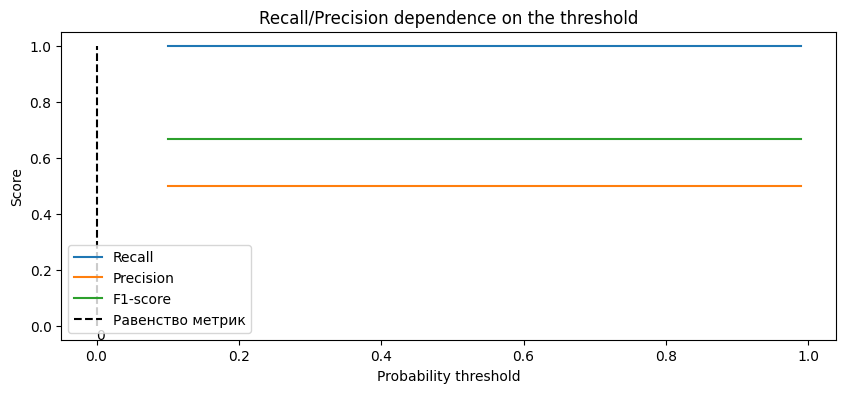

In [25]:
# считаем вероятности принадлежности к классам
y_test_proba_pred = grid_search.predict_proba(X_test)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)
# создадим списки, в которых будем хранить значения метрик
recall_scores = []
precision_scores = []
f1_scores = []
# сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.01)
for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    recall_scores.append(recall_score(y_test, y_test_pred))
    precision_scores.append(precision_score(y_test, y_test_pred))
    f1_scores.append(f1_score(y_test, y_test_pred))

x = 0
# найдём порог, при котором метрики пересекаются
for i, elem in enumerate(thresholds):
    if (recall_scores[i] == precision_scores[i]) and (recall_scores[i] == f1_scores[i]):
        x = elem
        break

# визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score')

ax.vlines(x=x, ymin=0, ymax=1, colors='black', linestyles='dashed', label='Равенство метрик')
ax.annotate(text=str(np.round(x, 2)), xy=(x, -0.05))
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

##### Видим, что метрики не становятся раными ни при каком пороге вероятности. И поскольку значения метрик не меняются ни при каком пороге вероятности, это означает, что модель определяет регионы по классам однозначно.

In [26]:
# из всего набора регионов оставляем только выбросы
outliers = merged_data_scaler.loc[list(regions_for_drop)]

# проводим для этих регионов понижение размерности, оставляя только 2 главные компоненты методом PCA
outliers_pca = pca.transform(outliers)
outliers_pca = pd.DataFrame(data=outliers_pca, index=outliers.index)

# делаем предсказание
outliers_pca['predict'] = grid_search.predict(outliers_pca)
outliers_pca['predict']

Севастополь                   0
Ленинградская область         0
Тюменская область             0
Республика Алтай              0
Ненецкий автономный округ     0
Сахалинская область           0
Калужская область             0
Республика Крым               0
Чукотский автономный округ    0
Name: predict, dtype: int64

##### Модель дерева решений определяет все регионы в один класс.
##### Поскольку нам нужно определить все регионы, население в которых нуждается в помощи, я предлагаю Республику Алтай тоже отнести всё-таки к классу 1, как это делает логистическая регрессия.
##### Определим регионы из 0-ого и 1-ого классов в разные датафреймы.

In [27]:
class_0 = agglomerative_pca[agglomerative_pca['predict'] == 1].index.to_list()
class_0.append('Республика Алтай')
class_0 = merged_data.loc[class_0]
class_0

,"Динамика населения на 2016 г., в %","Динамика населения на 2018 г., в %","Динамика населения на 2020 г., в %","Динамика населения на 2021 г., в %","Динамика населения на 2022 г., в %","Динамика среднедушевых денежных доходов на 2019 г., в %","Динамика среднедушевых денежных доходов на 2020 г., в %",Реальные денежные доходы в 2016 году в % к предыдущему году,Реальные денежные доходы в 2017 году в % к предыдущему году,Реальные денежные доходы в 2018 году в % к предыдущему году,...,Динамика новорождённых в 2020 году,Динамика новорождённых в 2021 году,"Отношение числа умерших за 2015 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2016 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2017 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2018 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2019 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2020 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2019 год детей в сельской местности к числу новорожденных, в %","Отношение числа умерших за 2020 год детей в сельской местности к числу новорожденных, в %"
Республика Дагестан,0.845681,0.722739,0.801393,0.721505,0.655985,6.418171,0.923088,91.1,100.9,96.9,...,2.175059,-4.678966,0.407499,0.372232,0.310004,0.287740,0.329554,0.292435,0.454785,0.389197
Республика Ингушетия,1.914881,1.575319,1.943735,1.676919,1.647516,2.790324,1.583002,100.0,99.3,100.9,...,6.092516,0.200874,0.587964,0.552622,0.375000,0.353669,0.325937,0.283587,0.288329,0.271771
Республика Кабардино-Балкария,0.179503,0.158944,0.246012,0.096850,0.149104,3.215573,2.249232,97.3,99.1,99.8,...,6.327083,-1.339117,0.300942,0.369125,0.261450,0.174616,0.260704,0.207469,0.240650,0.330064
Республика Карачаево-Черкессия,-0.269262,-0.027228,-0.007518,-0.036732,-0.244543,4.265692,0.680091,92.0,98.0,98.5,...,0.156556,-12.661196,0.396347,0.269058,0.213800,0.341571,0.215264,0.254005,0.313112,0.234467
Республика Чечня,1.744476,1.563117,1.494560,1.302878,1.227977,4.056559,1.897423,95.0,96.4,102.3,...,6.985255,0.777125,0.439842,0.381360,0.341251,0.240940,0.241606,0.361994,0.351750,0.239115
Республика Алтай,0.682255,0.486620,0.600824,0.351075,0.273813,3.860944,7.015205,95.7,101.9,103.0,...,-1.434290,-2.436548,0.124316,0.204551,0.261400,0.269946,0.266845,0.033841,0.833889,0.710660


In [28]:
class_1 = merged_data.loc[merged_data.index.difference(class_0.index)]
class_1.head()

,"Динамика населения на 2016 г., в %","Динамика населения на 2018 г., в %","Динамика населения на 2020 г., в %","Динамика населения на 2021 г., в %","Динамика населения на 2022 г., в %","Динамика среднедушевых денежных доходов на 2019 г., в %","Динамика среднедушевых денежных доходов на 2020 г., в %",Реальные денежные доходы в 2016 году в % к предыдущему году,Реальные денежные доходы в 2017 году в % к предыдущему году,Реальные денежные доходы в 2018 году в % к предыдущему году,...,Динамика новорождённых в 2020 году,Динамика новорождённых в 2021 году,"Отношение числа умерших за 2015 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2016 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2017 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2018 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2019 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2020 год детей в городской местности к числу новорожденных, в %","Отношение числа умерших за 2019 год детей в сельской местности к числу новорожденных, в %","Отношение числа умерших за 2020 год детей в сельской местности к числу новорожденных, в %"
Алтайский край,-0.337050,-0.659430,-0.671293,-0.897653,-1.226902,4.853476,-0.304967,94.7,100.0,99.7,...,-5.403230,-4.925911,0.425744,0.429556,0.415279,0.451237,0.255718,0.265318,0.284131,0.220264
Амурская область,-0.516624,-0.415091,-0.397129,-1.037664,-1.192179,7.651033,6.590800,92.1,101.1,102.4,...,-0.833439,-6.494333,0.482330,0.289101,0.296925,0.326246,0.340952,0.369286,0.202046,0.165542
Архангельская область,-0.851792,-0.961123,-0.714902,-0.893609,-1.189660,5.677919,2.887170,93.0,98.7,101.7,...,-7.824467,-4.704693,0.424216,0.465710,0.426840,0.365477,0.434693,0.269481,0.165597,0.056142
Астраханская область,-0.260554,-0.132697,-0.816812,-0.795799,-0.836659,5.496409,0.913059,90.1,97.1,100.6,...,-0.854157,-1.851343,0.598319,0.427470,0.422044,0.483051,0.490686,0.467418,0.163562,0.119146
Белгородская область,0.142189,-0.192483,0.111993,-0.509440,-0.606128,5.114042,1.511499,100.8,99.1,98.7,...,-6.410062,-1.044365,0.380654,0.417125,0.284523,0.279369,0.174269,0.202396,0.121230,0.178109


##### Определяем 0-ой класс как класс регионов, которомым необходимо выделить помощь.